In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0030.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.955118, 4.12166149)>


In [26]:
x = [101.839311,101.834507,101.755641,101.829614,101.810250,101.822584,101.744490,101.765208,101.735356,101.753151]
y = [03.929904,3.911874,3.933425,03.943406,3.939188,03.941496,04.009061,04.004846,3.993880,3.963151]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1V Reduced')
#file1 = 'reduceducdM_0030.fits'
#image1 = pf.getdata(file1)
file = 'reduceducdM_0031.fits'
image = pf.getdata(file)
#image = image1+image2

a = np.array(a)
b = np.array(b)
a = a-625
b = b-625
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[126.18497718 152.67995266 605.54131696 182.47820496 293.13259761
 222.62925642 673.61861306 554.74629143 725.07666219 621.4604631 ]
[583.56218392 687.07563725 567.83461394 506.75318313 531.93945138
 518.06589929 135.25427608 158.30137989 222.67684043 397.72517507]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
372  126.8795 582.26831 0.45403921 ...   0 182.65865 7.3148268 -2.1605101
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
435  153.7275 685.39719 0.42774416 ...   0 110.75084 4.6493161 -1.6684727
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
361 602.07222 566.76256 0.44118175 ...   0 139.26814 5.4963088 -1.8501778
 id xcentroid ycentroid sharpness  ... sky    peak      flux      ma

In [27]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=6) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

[  0.22828121 -14.85743407]
[[ 0.00044769 -0.00658125]
 [-0.00658125  0.09700453]]
Beta: [  0.24385889 -15.07837437]
Beta Std Error: [0.02151257 0.3190586 ]
Beta Covariance: [[ 2.40752364e-05 -3.56764423e-04]
 [-3.56764423e-04  5.29574040e-03]]
Residual Variance: 19.222692740906353
Inverse Condition #: 0.016372869857706474
Reason(s) for Halting:
  Sum of squares convergence


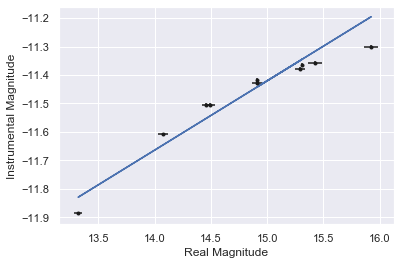

In [28]:
mags = np.array(mags)
realmag = [14.909,15.313,15.289,14.459,13.321,14.072,14.495,15.924,15.427,14.909]
realmag = np.array(realmag)
realmagerrors = [0.0032,0.0074,0.044,0.042,0.037,0.044,0.039,0.063,0.062,0.043]
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [29]:
xref = 416
yref = 372

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
254 622.14715 395.86889   0.428333 ...   0 178.79533 6.4826423 -2.0293801
235 416.04995 371.06789 0.39724516 ...   0 7810.1177 279.02358 -6.1141023


In [30]:
sourcemag = []
sourcemagerror = []
position = [(414.6347,371.67464)]
aperture = CircularAperture(position[0], r=6) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-13.779964630662695]


In [31]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

5.324430741037723 +/- 1.3901539001010028
